In [19]:
!pip install datasets
!pip install catboost
!pip install xgboost

In [20]:
from datasets import load_dataset

In [21]:
dataset = load_dataset('joelniklaus/brazilian_court_decisions')

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 3234
    })
    validation: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 404
    })
    test: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 405
    })
})

In [23]:
dataset['train'][0]

{'process_number': '0800304-08.2018.8.02.0000',
 'orgao_julgador': 'Tribunal Pleno',
 'publish_date': '12/03/2019',
 'judge_relator': 'Des. João Luiz Azevedo Lessa',
 'ementa_text': 'DIREITO PENAL E PROCESSUAL PENAL. REVISÃO CRIMINAL. ART. 621 DO CÓDIGO DE PROCESSO PENAL. REQUERENTE CONDENADO EM JÚRI POPULAR PELA PRÁTICA DOS CRIMES DE HOMICÍDIO DUPLAMENTE QUALIFICADO E HOMICÍDIO QUALIFICADO TENTADO. PLEITO DE REFAZIMENTO DA DOSIMETRIA DA PENA IMPOSTA AO REQUERENTE. ADMISSIBILIDADE NA VIA REVISIONAL. PRECEDENTES. ALEGAÇÃO DE ERRO NO PROCESSO DE DOSIMETRIA DA PENA. COMPORTAMENTO DA VÍTIMA. CIRCUNSTÂNCIA JUDICIAL NEUTRA QUE NÃO PODE SER CONSIDERADA DE FORMA DESFAVORÁVEL AO SENTENCIANDO SEGUNDO PRECEDENTES DO SUPERIOR TRIBUNAL DE JUSTIÇA E NOVO ENTENDIMENTO DA CÂMARA CRIMINAL DESTE TRIBUNAL DE JUSTIÇA. AFASTAMENTO. CULPABILIDADE. AUSÊNCIA DE EXPOSIÇÃO DE MOTIVOS PARA O INCREMENTO DA PENA-BASE. AFASTADO O DESVALOR. VALORAÇÃO ATRIBUÍDA ÀS CIRCUNSTÂNCIAS DO CRIME MANTIDA. FUNDAMENTAÇÃO IDÔNEA

In [24]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels = dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')


Train size: 3234 -- 3234
Test size: 405 -- 405


In [25]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [27]:
!python -m spacy download pt_core_news_sm

2023-12-01 15:08:58.548991: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 15:08:58.549048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 15:08:58.549079: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 15:09:00.269404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [28]:
import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

In [29]:
train_texts = preprocess_texts(train_texts)

Preprocessing: 100%|██████████| 3234/3234 [01:03<00:00, 50.58it/s]


In [30]:
test_texts = preprocess_texts(test_texts)

Preprocessing: 100%|██████████| 405/405 [00:11<00:00, 36.21it/s]


In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_option = 'binary'
# vectorizer_option = 'count'
# vectorizer_option = 'tf_idf'

vectorizer = None

if vectorizer_option == 'binary':
  vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'count':
  vectorizer = CountVectorizer(binary=False, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'tf_idf':
  vectorizer = TfidfVectorizer(max_features=None, ngram_range=(1, 1))

print(f'Vectorizer Option: {vectorizer_option}')

Vectorizer Option: binary


In [32]:
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f'\nExample Raw Text: {train_texts[0]}')
print(f'\nExample Vectorized Text: {X_train[0]}')


Example Raw Text: direito penal processual penal revisão criminal artigo 621 código processo penal requerente condenado júri popular prática crimes homicídio duplamente qualificado homicídio qualificado tentado pleito refazimento dosimetria pena imposta requerente admissibilidade via revisional precedentes alegação erro processo dosimetria pena comportamento vítima circunstância judicial neutra considerada desfavorável sentenciando precedentes superior tribunal justiça entendimento câmara criminal tribunal justiça afastamento culpabilidade ausência exposição motivos incremento pena-base afastado desvalor valoração atribuída circunstâncias crime mantida fundamentação idônea pena-base reduzida compensação agravante motivação torpe atenuante confissão espontânea pena privativa liberdade redimensionada crime tentado aplicada fração redutora máxima ante distância atos praticados requerente consumação crime pena redimensionada

Example Vectorized Text: [0 0 0 ... 0 0 0]


In [33]:
print(f'Vocabulary: {len(vectorizer.vocabulary_)}')

Vocabulary: 12447


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',
                                              max_iter=500),
    'Multinomial NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': svm.SVC(),
    'SGD': SGDClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(force_row_wise=True, verbose=-1),
    'CatBoost': CatBoostClassifier(silent=True),
    'MLP': MLPClassifier(),
    'XGBoost': XGBClassifier()
}


Classifier: Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       234
           1       0.66      0.66      0.66        93
           2       0.62      0.58      0.60        78

    accuracy                           0.74       405
   macro avg       0.70      0.69      0.69       405
weighted avg       0.74      0.74      0.74       405



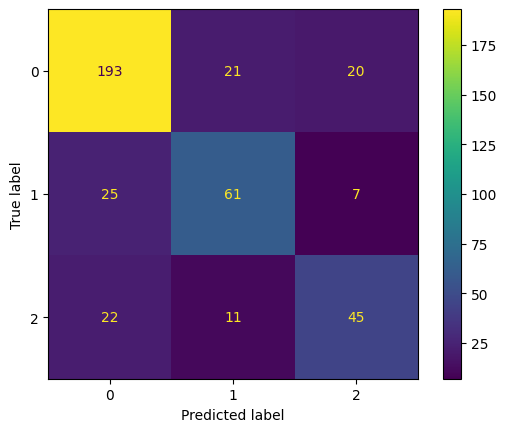


Classifier: Multinomial NB
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       234
           1       0.48      0.61      0.54        93
           2       0.48      0.56      0.52        78

    accuracy                           0.63       405
   macro avg       0.58      0.61      0.59       405
weighted avg       0.66      0.63      0.64       405



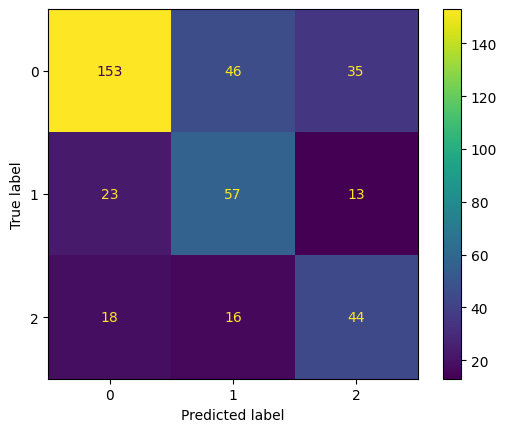


Classifier: KNN
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       234
           1       0.72      0.33      0.46        93
           2       0.53      0.42      0.47        78

    accuracy                           0.67       405
   macro avg       0.65      0.55      0.57       405
weighted avg       0.67      0.67      0.65       405



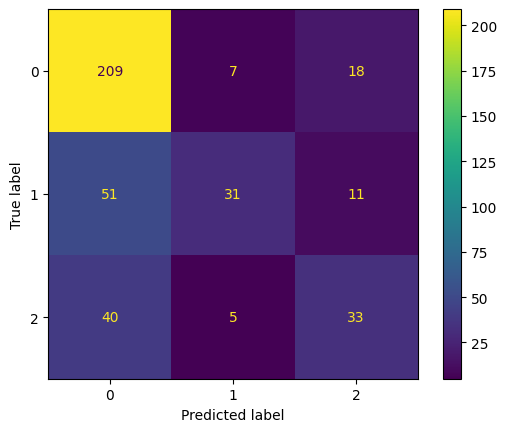


Classifier: Decision Tree
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       234
           1       0.57      0.53      0.55        93
           2       0.56      0.54      0.55        78

    accuracy                           0.68       405
   macro avg       0.63      0.62      0.62       405
weighted avg       0.67      0.68      0.68       405



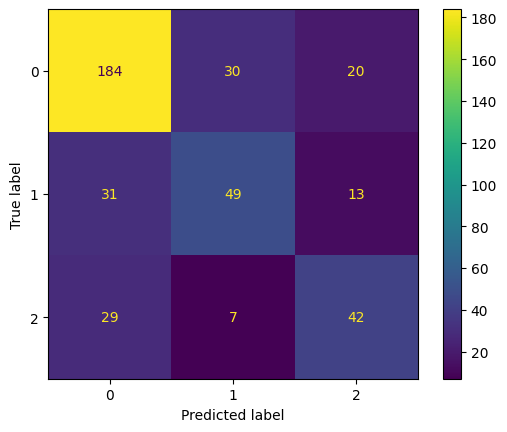


Classifier: SVM
              precision    recall  f1-score   support

           0       0.71      0.95      0.82       234
           1       0.78      0.46      0.58        93
           2       0.79      0.38      0.52        78

    accuracy                           0.73       405
   macro avg       0.76      0.60      0.64       405
weighted avg       0.74      0.73      0.71       405



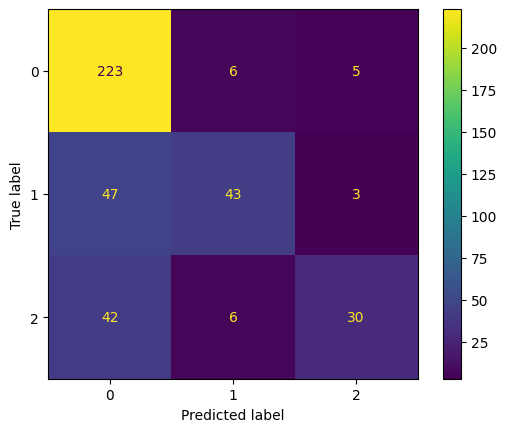


Classifier: SGD
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       234
           1       0.63      0.66      0.64        93
           2       0.57      0.49      0.52        78

    accuracy                           0.72       405
   macro avg       0.66      0.65      0.66       405
weighted avg       0.71      0.72      0.72       405



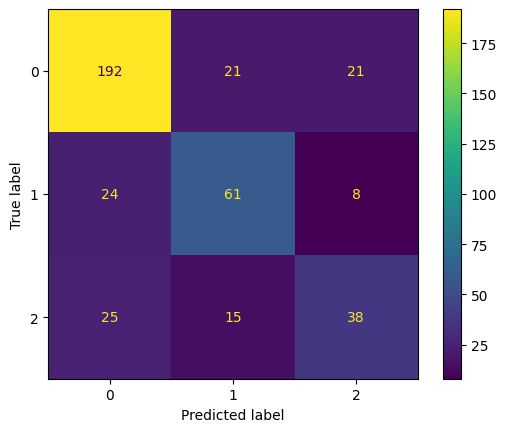


Classifier: Extra Trees
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       234
           1       0.80      0.46      0.59        93
           2       0.83      0.45      0.58        78

    accuracy                           0.75       405
   macro avg       0.79      0.62      0.67       405
weighted avg       0.76      0.75      0.73       405



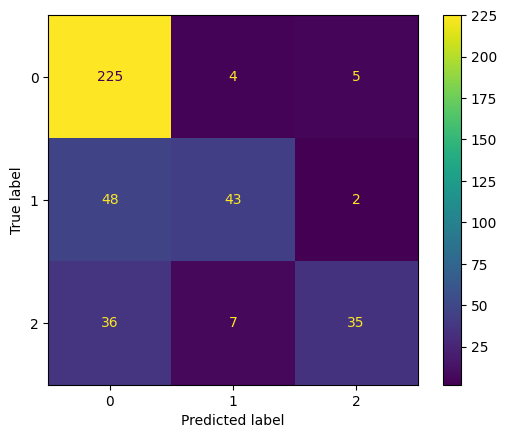


Classifier: Random Forest
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       234
           1       0.80      0.43      0.56        93
           2       0.79      0.35      0.48        78

    accuracy                           0.72       405
   macro avg       0.77      0.58      0.62       405
weighted avg       0.74      0.72      0.69       405



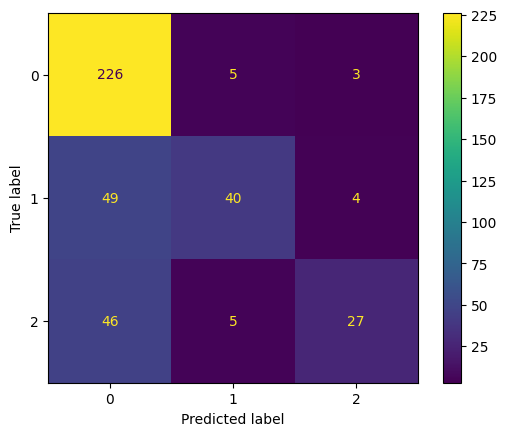


Classifier: LightGBM
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       234
           1       0.72      0.62      0.67        93
           2       0.73      0.62      0.67        78

    accuracy                           0.79       405
   macro avg       0.76      0.72      0.74       405
weighted avg       0.78      0.79      0.78       405



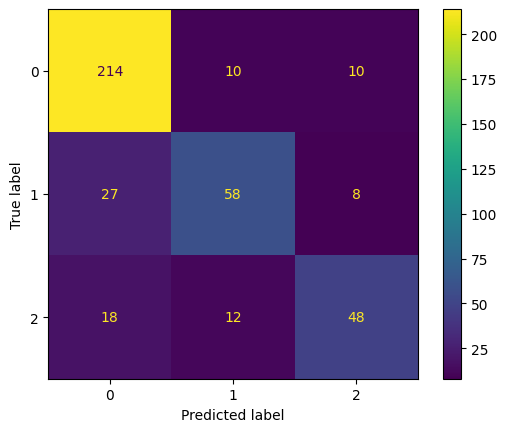


Classifier: CatBoost
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       234
           1       0.75      0.57      0.65        93
           2       0.76      0.41      0.53        78

    accuracy                           0.75       405
   macro avg       0.75      0.64      0.67       405
weighted avg       0.75      0.75      0.73       405



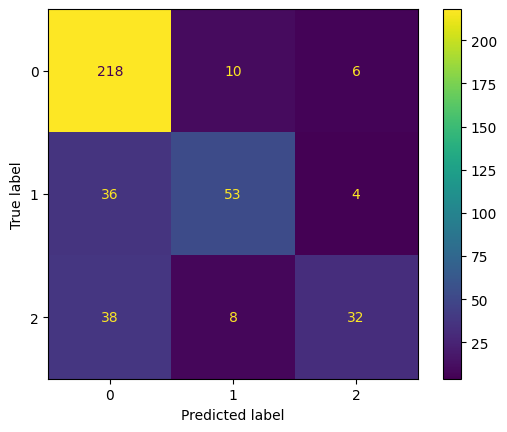


Classifier: MLP
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       234
           1       0.65      0.63      0.64        93
           2       0.62      0.44      0.51        78

    accuracy                           0.73       405
   macro avg       0.68      0.65      0.66       405
weighted avg       0.72      0.73      0.72       405



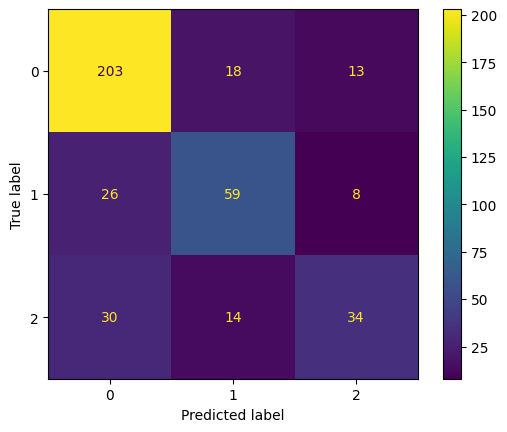


Classifier: XGBoost
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       234
           1       0.75      0.58      0.65        93
           2       0.71      0.59      0.64        78

    accuracy                           0.78       405
   macro avg       0.75      0.69      0.72       405
weighted avg       0.77      0.78      0.77       405



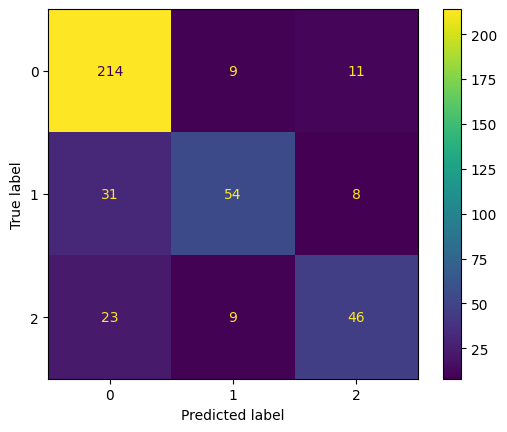

Vectorizer Option: binary


,Acurácia,Precisão,Cobertura,F1-Score
Logistic Regression,0.738272,0.735617,0.738272,0.736684
Multinomial NB,0.627160,0.657770,0.627160,0.636259
KNN,0.674074,0.670574,0.674074,0.647746
Decision Tree,0.679012,0.674389,0.679012,0.676272
SVM,0.730864,0.744538,0.730864,0.705008
SGD,0.718519,0.713942,0.718519,0.715479
Extra Trees,0.748148,0.764059,0.748148,0.725508
Random Forest,0.723457,0.743429,0.723457,0.691872
LightGBM,0.790123,0.783940,0.790123,0.783967
CatBoost,0.748148,0.749506,0.748148,0.730054


In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

results = {}

for classifier_name, classifier in classifiers.items():

  print(f'\nClassifier: {classifier_name}')

  classifier.fit(X_train, train_labels)

  y_pred = classifier.predict(X_test)

  report = classification_report(test_labels, y_pred)

  print(report)

  ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

  plt.show()

  report = classification_report(test_labels, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df.to_csv(vectorizer_option + '_' + classifier_name + '.csv')

  results.update({classifier_name :
                      { 'Acurácia': df.loc['accuracy'][0],
                        'Precisão': df.loc['weighted avg']['precision'],
                        'Cobertura': df.loc['weighted avg']['recall'],
                        'F1-Score': df.loc['weighted avg']['f1-score']}
                  })

print(f'Vectorizer Option: {vectorizer_option}')
df_results = pd.DataFrame.from_dict(results, orient='index')
df_results